# Deep Learning Project Facial Expression Classification
---

![](https://i.ytimg.com/vi/wlaR5F30hiU/maxresdefault.jpg)



### Outline of this Notebook
---
1. [**Data Preparation**](#1.-Data-Preparation)
2. [**Model-Architecture**](#2.-Model-Architecture)
3. [**Model Evaluation**](#3.-Model-Evaluation)


---

# 1. Data Preparation

Here, we obtaind the dataset from the Kaggle competition **"Challenges in Representation Learning: Facial Expression Recognition Challenge"**.  
From Kaggle open resource, we had:
+ training dataset, 
+ public test dataset (which is then used as validation dataset for our project), 
+ and further a private dataset (same size with public test dataset and will be used as data for evaluating the prediction performance).  

It is noteworthy that in original provided dataset (either in training dataset or in public test dataset), we have actually in total **7 categories**, apart from
1. Angry, 
1. Surprise, 
1. Fear, 
1. Happy, 
1. Sad and 
1. Neutral  
that has been presented in our slides, we had an additional tag of 
1. Disgust.  
However, the main problem will be that we have a quite unbalanced distribution of Disgust label in provided data, it accounts for a unusually low percentage, the obvious unbalance in data distribution will influence further neural network training.  

Therefore we re-classify all pictures with "Disgust" label into "Angry" label.   
Such re-classification is relatively subjective, completely based on our perception of those two labels. Both of our teammates believe that the muscle movements in Angry face looks highly similar to that for Disgust faces. 

The data set is available at the following URL: https://www.kaggle.com/deadskull7/fer2013?select=fer2013.csv

**Install the needed dependencies.**

In [1]:
!pip install brewer2mpl

Load the `fer20131.csv` into the project and load it in the notebook using the **Insert to code > pandas DataFrame**

In [2]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_6ab35eef88f846c0946632a5fb5dc496 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_6ab35eef88f846c0946632a5fb5dc496 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_6ab35eef88f846c0946632a5fb5dc496 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='-n9uxWTa1Q4nqsvPs2BOCk-HF2MhvZIjMcTwRDhRzIkp',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_6ab35eef88f846c0946632a5fb5dc496)

body = client_6ab35eef88f846c0946632a5fb5dc496.get_object(Bucket='edhec2018-donotdelete-pr-2xicptjt6wswei',Key='fer20131.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

     |████████████████████████████████| 489.6 MB 42 kB/s s eta 0:00:01100:02
     |████████████████████████████████| 13.4 MB 75.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 68.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 74.8 MB/s eta 0:00:01
     |████████████████████████████████| 463 kB 80.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 74.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 73.1 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 20210226132247
    Uninstalling flatbuffers-202

In [5]:
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import random
import sys
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import brewer2mpl


def emotion_count(y_train, classes):
    """
    The function re-classify picture with disgust label into angry label
    """
    emo_classcount = {}
    print ('Disgust classified as Angry')
    y_train.loc[y_train == 1] = 0
    classes.remove('Disgust')
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

def load_data(sample_split=0.3, usage='Training',classes=['Angry','Happy'], filepath='../input/fer20131.csv'):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    
    """
    At this stage you should have used the Insert to Code > pandas DataFrame option from the Find and Add Data pane
    
    
    """  
    #df = pd.read_csv(filepath)
    df = df_data_1
    
    df = df[df.Usage == usage]
    frames = []
    classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)*sample_split))
    data = data.loc[rows]
    x = list(data["pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    ## reshape into 48*48*1 and rescale
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train

2021-12-07 14:22:50.011310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ibm/dsdriver/lib:/opt/oracle/lib:/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/tensorflow


In [6]:
## All three datasets are well loaded accordingly
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

X_test, y_test = load_data(sample_split=1.0,classes=emo,
usage='PrivateTest')

X_train, y_train = load_data(sample_split=1.0,classes=emo,
usage= 'Training')

X_val,y_val = load_data(sample_split=1.0,classes=emo,
usage= 'PublicTest')

Disgust classified as Angry
Disgust classified as Angry
Disgust classified as Angry


In [7]:
## The shape of loaded data is under examination
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(28709, 48, 48, 1)
(28709, 6)
(3589, 48, 48, 1)
(3589, 6)
(3589, 48, 48, 1)
(3589, 6)


After successfully loading the training, validation and testing dataset, we know had an input with dimension 48*48*1, one channel is used since we only have greyscale picture instead of colorful pictures stored in RGB format, for output, we had 6 labels. Fot training dataset, we had a sample size as large as 28709 while validation as well as test dataset own a sample size of 3589. Overall, we had a pretty large dataset.

In [8]:
def save_data(X_test, y_test, fname=''):
    """
    The function stores loaded data into numpy form for further processing
    """
    np.save( 'X_test' + fname, X_test)
    np.save( 'y_test' + fname, y_test)
save_data(X_test, y_test,"_privatetest6_100pct")
X_fname = 'X_test_privatetest6_100pct.npy'
y_fname = 'y_test_privatetest6_100pct.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print ('Private test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print (zip(labels, counts))

Private test set


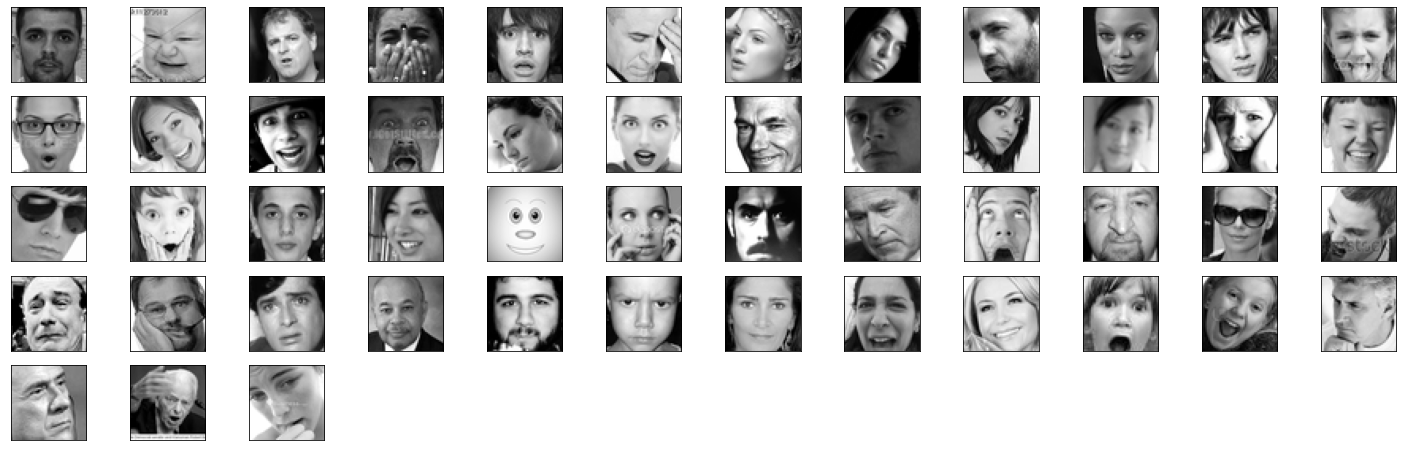

In [10]:
def overview(start, end, X):
    """
    The function is used to plot first several pictures for overviewing inputs format
    """
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=plt.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,100, X)

(1, 48, 48, 1)


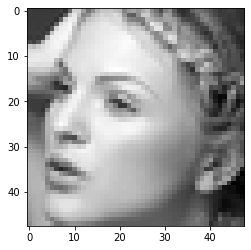

In [11]:
## Similarly we can visualize any input with self-defined index with following code
input_img = X[6:7,:,:,:] 
print (input_img.shape)
plt.imshow(input_img[0,:,:,0], cmap='gray')
plt.show()

In [12]:
y_train = y_train 
y_public = y_val 
y_private = y_test 
y_train_labels  = [np.argmax(lst) for lst in y_train]
y_public_labels = [np.argmax(lst) for lst in y_public]
y_private_labels = [np.argmax(lst) for lst in y_private]

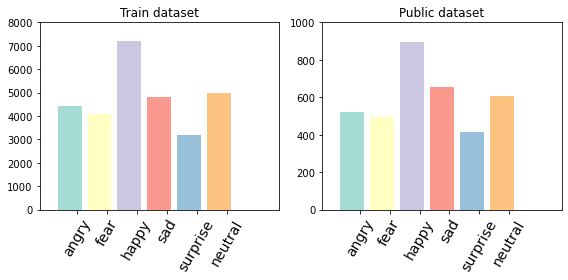

In [13]:
def plot_distribution(y1, y2, data_names, ylims =[1000,1000]): 
    """
    The function is used to plot the distribution of the labels of provided dataset 
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,7), np.bincount(y1), color=colorset, alpha=0.8)
    ax1.set_xticks(np.arange(1.25,7.25,1))
    ax1.set_xticklabels(labels, rotation=60, fontsize=14)
    ax1.set_xlim([0, 8])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(np.arange(1,7), np.bincount(y2), color=colorset, alpha=0.8)
    ax2.set_xticks(np.arange(1.25,7.24,1))
    ax2.set_xticklabels(labels, rotation=60, fontsize=14)
    ax2.set_xlim([0, 8])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_train_labels, y_public_labels, \
                  ['Train dataset', 'Public dataset'], \
                  ylims =[8000,1000]) 

# 2. Model Architecture

Here, we first approached this project by specifying out clearly our primary purpose--classify provided greyscale pictures into one out of six labels. 
The picture classification task natually leads us to well-known Convolutional Neural Network (CNN). 
After researching around how CNN usually performs for greyscale picture, we decided to start from three sequential convolutional layers followed by a maxpooling layer, common activation function for convolutional layer "relu" is used, as well as the same padding pattern. 
Then, from the basic structure, we further added more and more convolutional layers with different features captured. The features to be captured from convolutional layer increased from 32 to 128, it is suggested that such hierarchical structure (with increasing layer nodes) performs better for deep neural network. 

Finally, the convolved layer is first flattened and then go through two more dense layers to reach the output layer in which softmax activation function is used for multiclass classification (six classes in total).

In [14]:
# Final Model Architecture:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

modelN = models.Sequential()
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        input_shape=(48, 48, 1)))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(6, activation='softmax'))

# optimizer:
modelN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print ('Training....')


#fit
nb_epoch = 5
batch_size = 64

modelF = modelN.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,
          validation_data=(X_val, y_val), shuffle=True, verbose=1)

2021-12-07 14:24:59.340605: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ibm/dsdriver/lib:/opt/oracle/lib:/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/tensorflow
2021-12-07 14:24:59.340656: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Training....
Epoch 1/5
449/449 [==============================] - 280s 622ms/step - loss: 1.7630 - accuracy: 0.2490 - val_loss: 1.7612 - val_accuracy: 0.2494
Epoch 2/5
449/449 [==============================] - 277s 618ms/step - loss: 1.7246 - accuracy: 0.2651 - val_loss: 1.5909 - val_accuracy: 0.3413
Epoch 3/5
449/449 [==============================] - 265s 591ms/step - loss: 1.4890 - accuracy: 0.3964 - val_loss: 1.3822 - val_accuracy: 0.4525
Epoch 4/5
449/449 [==============================] - 261s 581ms/step - loss: 1.3463 - accuracy: 0.4626 - val_loss: 1.3338 - val_accuracy: 0.4770
Epoch 5/5
449/449 [==============================] - 275s 612ms/step - loss: 1.2545 - accuracy: 0.5048 - val_loss: 1.2639 - val_accuracy: 0.5032


# 3. Model Evaluation

INFO:tensorflow:Assets written to: facial_1/assets


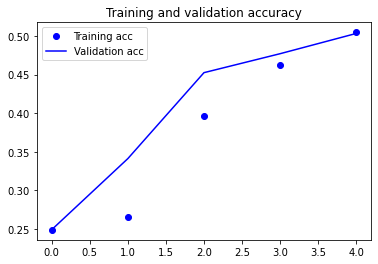

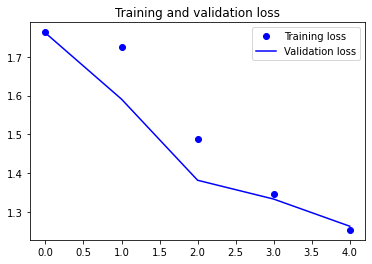

In [19]:
modelN.save('facial_1')

acc = modelF.history['accuracy']
val_acc = modelF.history['val_accuracy']
loss = modelF.history['loss']
val_loss = modelF.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
# evaluate model on private test set
score = modelN.evaluate(X, y, verbose=0)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

model accuracy: 49.68%


In [21]:
# prediction and true labels
y_prob = modelN.predict(X, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y]

In [26]:
import matplotlib

In [22]:
def plot_subjects(start, end, y_pred, y_true, title=False):
    """
    The function is used to plot the picture subjects
    """
    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]], color='#53b3cb',fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [23]:
import brewer2mpl
def plot_probs(start,end, y_prob):
    """
    The function is used to plot the probability in histogram for six labels 
    """
    fig = plt.figure(figsize=(12,12))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
        ax.bar(np.arange(0,6), y_prob[i], color=set3,alpha=0.5)
        ax.set_xticks(np.arange(0.5,6.5,1))
        labels = ['angry', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [24]:
def plot_subjects_with_probs(start, end, y_prob):
    """
    This plotting function is used to plot the probability together with its picture
    """
    iter = int((end - start)/6)
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

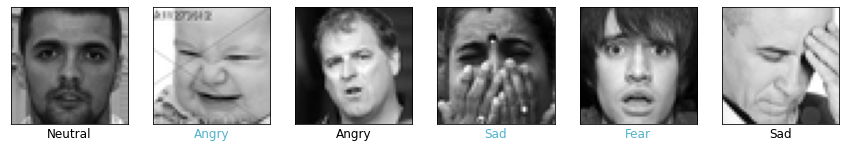

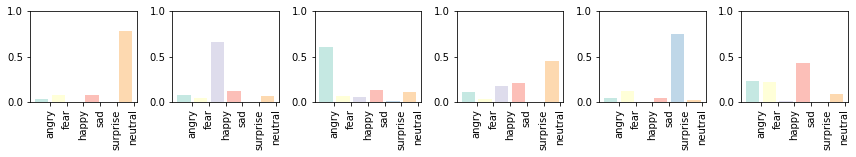

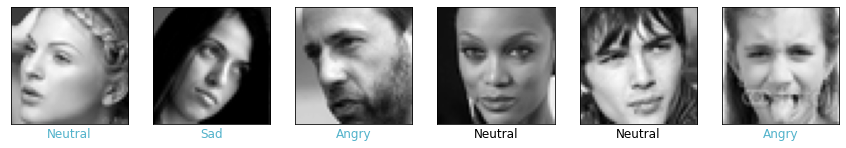

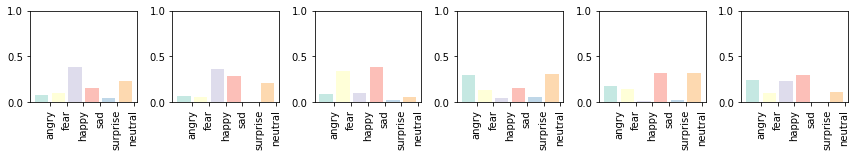

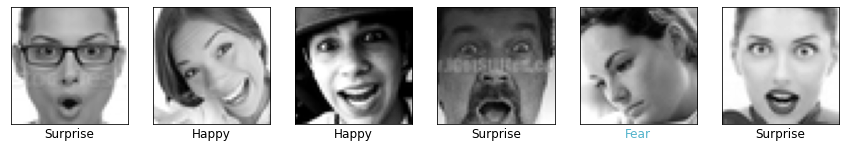

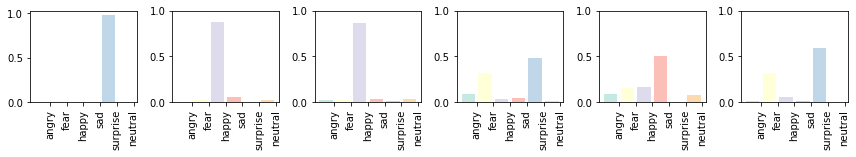

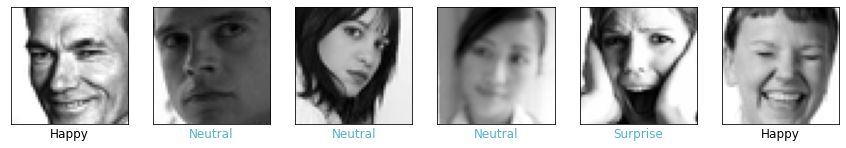

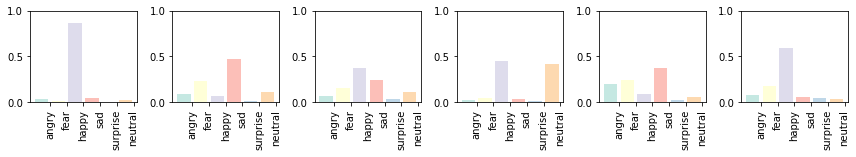

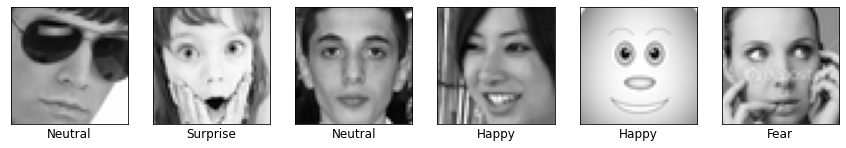

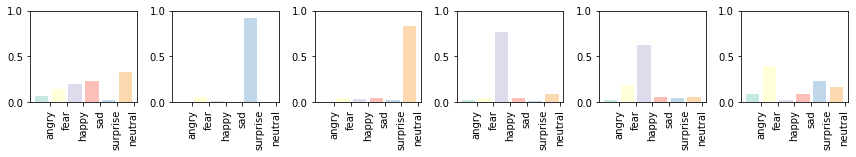

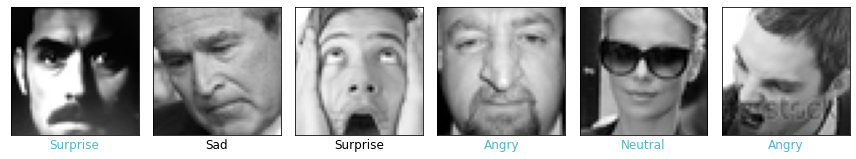

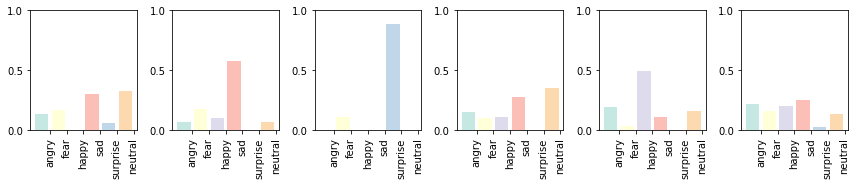

In [27]:
plot_subjects_with_probs(0, 36, y_prob)

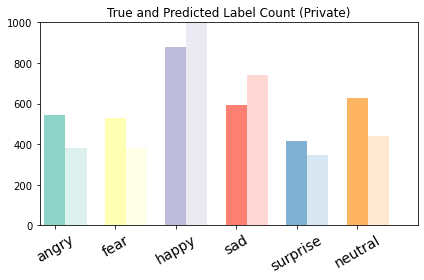

In [28]:
def plot_distribution2(y_true, y_pred):
    """
    The function is used to compare the number of true labels as well as prediction results
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    ind = np.arange(1.5,7,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=colorset, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=colorset, alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 7.5])
    ax.set_ylim([0, 1000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()
    
plot_distribution2(y_true, y_pred)

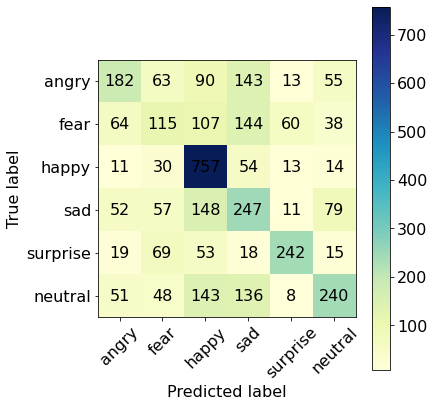

In [29]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    """
    The function is used to construct the confusion matrix 
    """
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)
plt.show()

From above, we have performed several visulization methods to evaluate our trained CNN. First, we plotted the training accuracy/loss versus validation accuracy/loss, from the above plot, we can easily find out that our model actually starts to overfit around 10 epoches, at which validation accuracy reaches its plateau, only oscillated around a stable line while validation loss started to increase. Therefore, we take the validation accuracy 58.62% at epoch 9 as the reported validation accuracy and the validation loss will be around 1.1736. We all know that when predicting one out of six labels randomly, we will have a baseline accuracy around 1/6=16.67%, the validation accuracy as high as 58.62% is satisfactory enough. Therefore, we decided to further examine how our model performs on test dataset.

First, we evaluated our trained CNN on test dataset, the returned test accuracy is still as high as 55.25%. Second, we attempted to plot the input together with its corresponding true label as well as the softmax output (in which a probability will be outputed for each label) in the same plot for test dataset (first 36 pictures are choosen). When the true label is equal to the class with highest probability, we will mark the true label with Black color, otherwise Blue color indicated a wrong classification. From the first 36 outputs, we can easily find out that the softmax output can be pure (Only one class owns a probability larger than 0.9) or relatively impure (two or three classes shares the probability). Some of the pictures are even completely misclassified, for example, object 26 is labled as happy but misclassified by our neural network as angry with nearly 100% certainty. However, the picture can also be perceived easily as angry even by human. Therefore, facial expressions are indeed very difficult to classify due to complicated muscle movements. Further, we decide to display the prediction results with a plot parallelly showing true label counts and prediction label counts side by side. It is noteworthy from the plot that overall, the true counts are very similar to prediction counts. However, considering the test accuracy 55.25% we obtained, there should be some labels completely and easily classified to another label. Finally,the result can be revealed by the confusion matrix. It suggested the label which is most successfully classified is happy, that makes perfect sense given happy data accounts for the main percentage in training data. The label-pair that can cause misclassification will be neutral-sad as well as sad-fear. Based on human perception, we believe the result is pretty reasonable. 